In [27]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Create the Blackjack environment
env = gym.make("Blackjack-v1", sab=True)  # use "Blackjack-v0" if gym <0.26

In [28]:
def random_policy(state):
    return env.action_space.sample()

def run_random_agent(episodes=10000):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = random_policy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        rewards.append(reward)
    return rewards

In [29]:
# Run and evaluate
random_rewards = run_random_agent()
print(f"Random Policy average reward over 10k episodes: {np.mean(random_rewards):.4f}")

Random Policy average reward over 10k episodes: -0.4049


In [30]:
def one_move_policy(state):
    player_sum, _, _ = state
    return 0 if player_sum < 18 else 1  # 0 = hit, 1 = stand

def run_one_move_agent(episodes=10000):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = one_move_policy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        rewards.append(reward)
    return rewards

In [31]:
# Run and evaluate
one_move_rewards = run_one_move_agent()
print(f"One-Move Policy average reward over 10k episodes: {np.mean(one_move_rewards):.4f}")

One-Move Policy average reward over 10k episodes: -0.5573


In [32]:
def train_q_agent(episodes=500_000, alpha=0.1, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(2))  # 2 actions: hit or stand

    for _ in range(episodes):
        state = env.reset()[0]
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            best_next = 0 if done else np.max(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])
            state = next_state
    return Q

In [33]:
def evaluate_q_policy(Q, episodes=10000):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        rewards.append(reward)
    return rewards

In [34]:
# Train Q-learning agent
Q = train_q_agent(episodes=500_000)

# Evaluate
q_learning_rewards = evaluate_q_policy(Q)
print(f"Q-Learning Policy average reward over 10k episodes: {np.mean(q_learning_rewards):.4f}")

Q-Learning Policy average reward over 10k episodes: -0.0739


In [35]:
def plot_results(results_dict):
    for label, rewards in results_dict.items():
        avg = np.convolve(rewards, np.ones(1000)/1000, mode='valid')
        plt.plot(avg, label=label)
    plt.title("Blackjack Baseline Agents")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

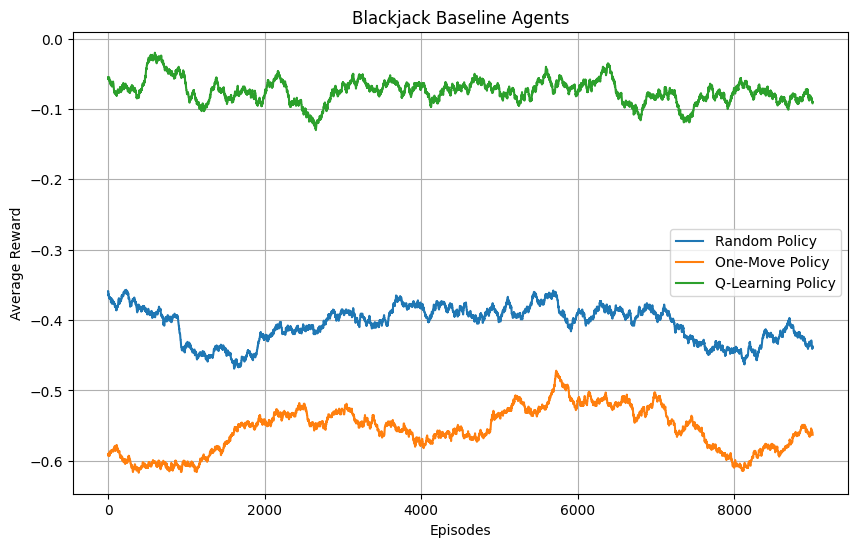

In [36]:
plt.figure(figsize=(10, 6))
plot_results({
    "Random Policy": random_rewards,
    "One-Move Policy": one_move_rewards,
    "Q-Learning Policy": q_learning_rewards,
})

In [37]:
# Grid search parameters
alpha_values = [0.01, 0.05, 0.1, 0.2]
gamma_values = [0.7, 0.8, 0.9, 0.99]
epsilon_values = [0.1, 0.2, 0.4, 0.6]

best_params = None
best_reward = -np.inf

for alpha in alpha_values:
    for gamma in gamma_values:
        for epsilon in epsilon_values:
            print(f"Training with alpha={alpha}, gamma={gamma}, epsilon={epsilon} ...")
            Q = train_q_agent(episodes=500_000, alpha=alpha, gamma=gamma, epsilon=epsilon)
            rewards = evaluate_q_policy(Q, episodes=10000)
            avg_reward = np.mean(rewards)
            print(f"Avg reward: {avg_reward:.4f}")

            if avg_reward > best_reward:
                best_reward = avg_reward
                best_params = (alpha, gamma, epsilon)

print(f"Best params: alpha={best_params[0]}, gamma={best_params[1]}, epsilon={best_params[2]}")
print(f"Best average reward over 10k episodes: {best_reward:.4f}")

Training with alpha=0.01, gamma=0.7, epsilon=0.1 ...
Avg reward: -0.0453
Training with alpha=0.01, gamma=0.7, epsilon=0.2 ...
Avg reward: -0.0579
Training with alpha=0.01, gamma=0.7, epsilon=0.4 ...
Avg reward: -0.0335
Training with alpha=0.01, gamma=0.7, epsilon=0.6 ...
Avg reward: -0.0505
Training with alpha=0.01, gamma=0.8, epsilon=0.1 ...
Avg reward: -0.0441
Training with alpha=0.01, gamma=0.8, epsilon=0.2 ...
Avg reward: -0.0474
Training with alpha=0.01, gamma=0.8, epsilon=0.4 ...
Avg reward: -0.0530
Training with alpha=0.01, gamma=0.8, epsilon=0.6 ...
Avg reward: -0.0316
Training with alpha=0.01, gamma=0.9, epsilon=0.1 ...
Avg reward: -0.0378
Training with alpha=0.01, gamma=0.9, epsilon=0.2 ...
Avg reward: -0.0499
Training with alpha=0.01, gamma=0.9, epsilon=0.4 ...
Avg reward: -0.0551
Training with alpha=0.01, gamma=0.9, epsilon=0.6 ...
Avg reward: -0.0360
Training with alpha=0.01, gamma=0.99, epsilon=0.1 ...
Avg reward: -0.0507
Training with alpha=0.01, gamma=0.99, epsilon=0.2 